In [53]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [54]:
import sys
sys.path.append('C://Users//faizan//Documents//CVProject')

Load The Data

In [55]:
import os

# Set the dataset path relative to the Jupyter Notebook's location
dataset = 'C://Users//faizan//Documents//CVProject//archive//fire_dataset'

# Function to walk through the directory and print its contents
def list_directory_contents(path):
    for dirpath, dirnames, filenames in os.walk(path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# Use the function to list the contents of the dataset directory
list_directory_contents(dataset)

There are 2 directories and 0 images in 'C://Users//faizan//Documents//CVProject//archive//fire_dataset'.
There are 0 directories and 755 images in 'C://Users//faizan//Documents//CVProject//archive//fire_dataset\fire_images'.
There are 0 directories and 244 images in 'C://Users//faizan//Documents//CVProject//archive//fire_dataset\non_fire_images'.


In [56]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [57]:
len(list(image_dir.glob(r'**/*.png')))

999

In [30]:
image_df

Filepath            Label
0    C:\Users\faizan\Documents\CVProject\archive\fi...      fire_images
1    C:\Users\faizan\Documents\CVProject\archive\fi...      fire_images
2    C:\Users\faizan\Documents\CVProject\archive\fi...      fire_images
3    C:\Users\faizan\Documents\CVProject\archive\fi...      fire_images
4    C:\Users\faizan\Documents\CVProject\archive\fi...      fire_images
..                                                 ...              ...
994  C:\Users\faizan\Documents\CVProject\archive\fi...  non_fire_images
995  C:\Users\faizan\Documents\CVProject\archive\fi...  non_fire_images
996  C:\Users\faizan\Documents\CVProject\archive\fi...  non_fire_images
997  C:\Users\faizan\Documents\CVProject\archive\fi...  non_fire_images
998  C:\Users\faizan\Documents\CVProject\archive\fi...  non_fire_images

[999 rows x 2 columns]

VISUALIZING IMAGES

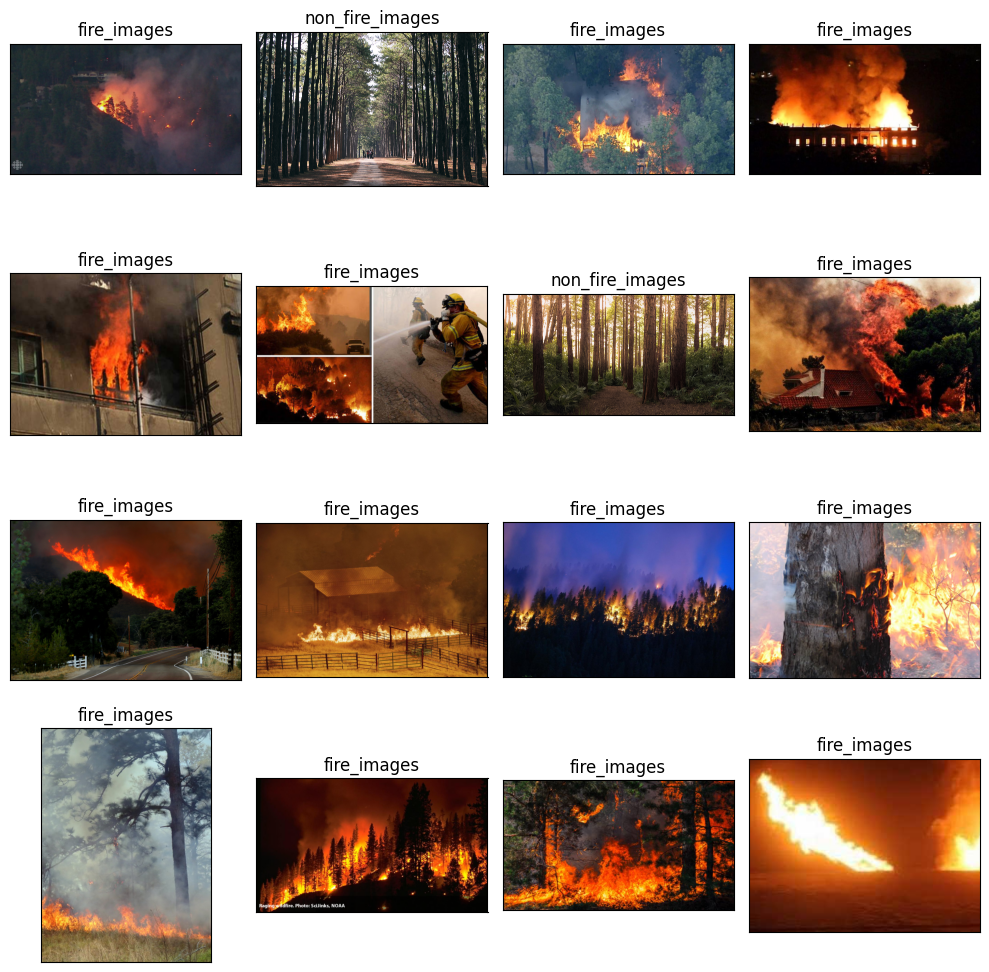

In [59]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

DATA PREPROCESSING

In [60]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [61]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [62]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 640 validated image filenames belonging to 2 classes.
Found 159 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [63]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

MODEL TRAINING

In [64]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [65]:
# Create checkpoint callback
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [66]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [67]:
# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="training_logs/fire_classification", 
                                   histogram_freq=1)


In [68]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        tensorboard_callback,
        checkpoint_callback,
    ]
)

Epoch 1/100
20/20 [==============================] - 40s 2s/step - loss: 0.5308 - accuracy: 0.7375 - val_loss: 0.2758 - val_accuracy: 0.8931
Epoch 2/100
20/20 [==============================] - 31s 2s/step - loss: 0.2042 - accuracy: 0.9406 - val_loss: 0.1729 - val_accuracy: 0.9497
Epoch 3/100
20/20 [==============================] - 31s 2s/step - loss: 0.1167 - accuracy: 0.9609 - val_loss: 0.1392 - val_accuracy: 0.9497
Epoch 4/100
20/20 [==============================] - 31s 2s/step - loss: 0.0893 - accuracy: 0.9719 - val_loss: 0.1357 - val_accuracy: 0.9497
Epoch 5/100
20/20 [==============================] - 30s 2s/step - loss: 0.0622 - accuracy: 0.9828 - val_loss: 0.1325 - val_accuracy: 0.9434
Epoch 6/100
20/20 [==============================] - 31s 2s/step - loss: 0.0535 - accuracy: 0.9859 - val_loss: 0.1225 - val_accuracy: 0.9560
Epoch 7/100
20/20 [==============================] - 29s 1s/step - loss: 0.0366 - accuracy: 0.9953 - val_loss: 0.1133 - val_accuracy: 0.9560
Epoch 8/100
2

PREDICTIONS

In [69]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.05564
Test Accuracy: 98.50%


LOSS CURVES

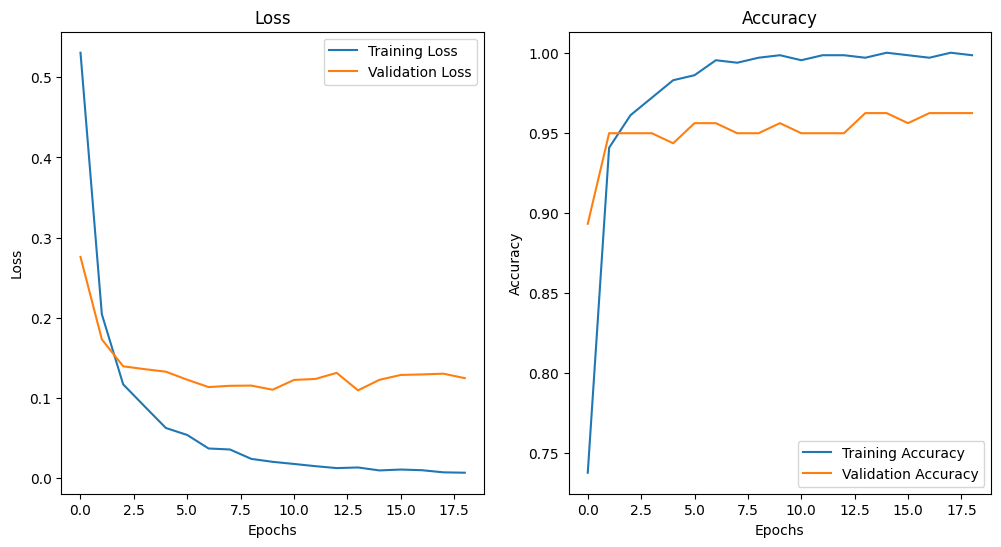

In [70]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

PREDICTIONS ON TEST DATA

In [71]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 [==============================] - 8s 979ms/step
The first 5 predictions: ['fire_images', 'fire_images', 'fire_images', 'fire_images', 'fire_images']


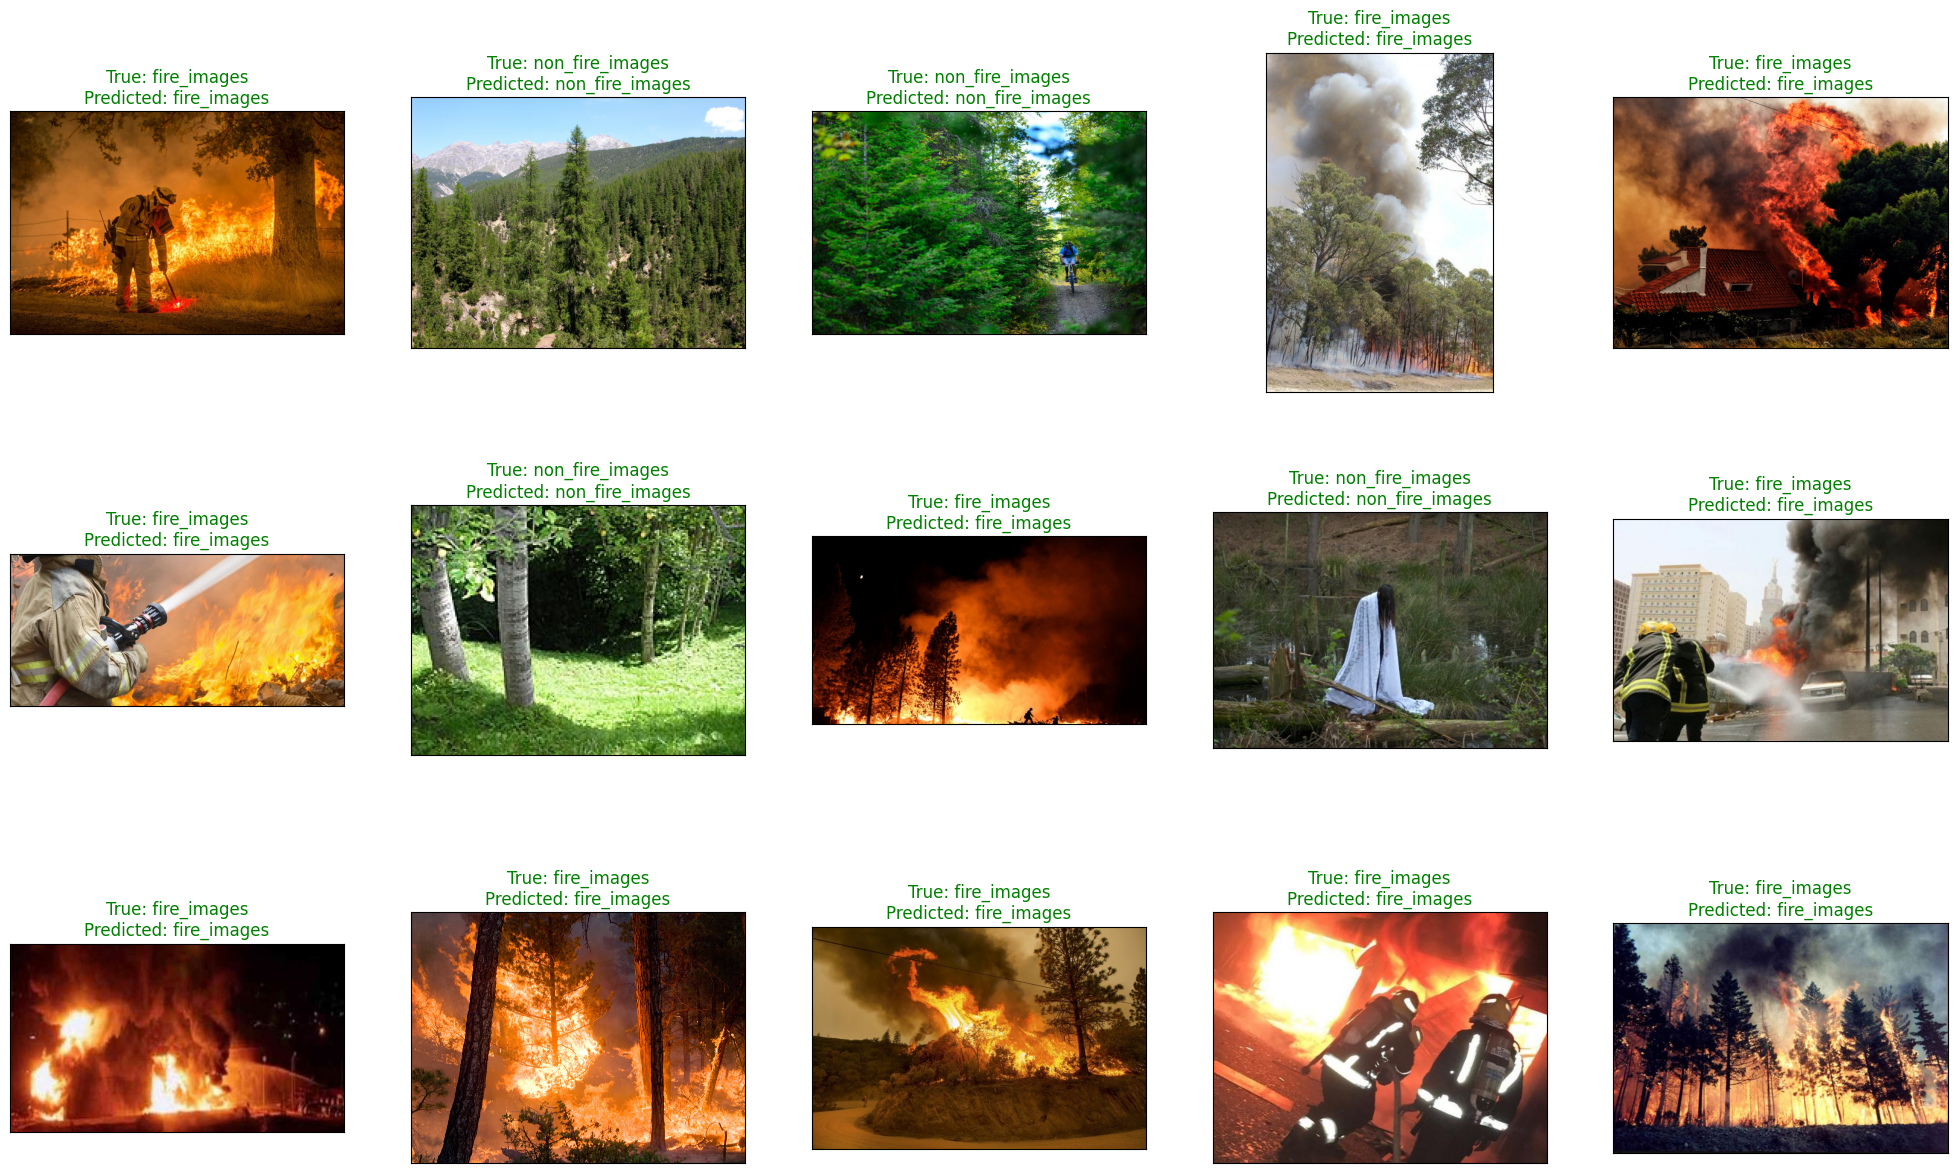

<Figure size 640x480 with 0 Axes>

In [72]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [75]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    fire_images       0.99      0.99      0.99       148
non_fire_images       0.98      0.96      0.97        52

       accuracy                           0.98       200
      macro avg       0.98      0.98      0.98       200
   weighted avg       0.98      0.98      0.98       200



In [76]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score  support
fire_images       0.986577  0.993243  0.989899  148.000
non_fire_images   0.980392  0.961538  0.970874   52.000
accuracy          0.985000  0.985000  0.985000    0.985
macro avg         0.983485  0.977391  0.980386  200.000
weighted avg      0.984969  0.985000  0.984952  200.000

In [77]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


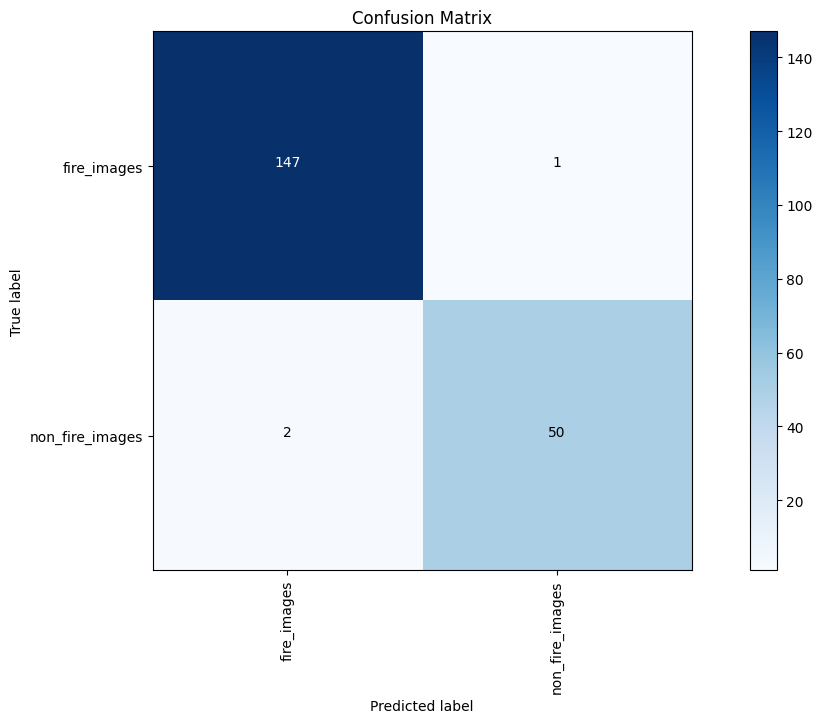

In [78]:
make_confusion_matrix(y_test, pred, list(labels.values()))